In [1]:
import pytrec_eval
import pandas as pd
import os
import numpy as np
import ir_datasets
import json
from repro_eval.util import arp, arp_scores

# Load run metadata

In [2]:
table = []
for run in os.listdir("../data/run"):
    parts = run.split("-")
    fields = {"dataset":  "-".join(parts[1:-4]),
    "subcollection":  parts[-4],
    "queries": parts[-3],
    "method": parts[-2],
    "implementation": parts[-1],
    "filename": run}
    table.append(fields)

In [3]:
runs = pd.DataFrame(table)

In [4]:
# runs = runs[~((runs["subcollection"]=="WT") & (runs["queries"]!="queries"))]  # longeval WT all
runs = runs[~((runs["subcollection"]=="WT") & (runs["queries"]!="test"))]  # longeval WT test only

In [5]:
# limit to systems of interrest
runs = runs[runs["method"].isin(["bm25", "bm25+colbert", "bm25+monot5", "rrf(xsqram__bm25_bo1__pl2)", "bm25_d2q10"])]

# Evaluate `arp`

In [6]:
def get_qrels_name_from_row(row):
    qrels_name = row.dataset+"-"+row.subcollection+".qrels"
    if row.queries != "queries":
        qrels_name += "-" + row.queries
    if row.dataset in qrels_type.keys():
        qrels_name += "-" + qrels_type[row.dataset]

    return qrels_name + "-core_queries"

In [7]:
def load_evaluator_with_qrels(qrels_name):
    with open("../data/qrels/"+qrels_name, "r") as file:
        qrels = pytrec_eval.parse_qrel(file)
    evaluator = pytrec_eval.RelevanceEvaluator(qrels, pytrec_eval.supported_measures)
    return evaluator

In [8]:
def evaluate_arp(row):
    evaluator = load_evaluator_with_qrels(get_qrels_name_from_row(row))
    with open("../data/run/"+row.filename, "r") as file:
        run = pytrec_eval.parse_run(file)
    arp = evaluator.evaluate(run)
    return arp

In [9]:
qrels_type = {
        "tripclick-test-head": "test-head-dctr"
}

In [10]:
runs["arp_per_topic"]=runs.apply(evaluate_arp, axis=1)

In [11]:
runs["arp"]=runs["arp_per_topic"].apply(arp_scores)

In [12]:
# explode ARP cell to generate a column per measure
runs = pd.concat([runs.drop(['arp'], axis=1), runs['arp'].apply(pd.Series)], axis=1)

# Plot ARP

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import defaultdict
sns.set_style("darkgrid")

In [14]:
def plot_arp(dataset, title, measures=["ndcg", "bpref", "P_10"], symbols=["-P","-o","-v","-s", "-d", "-*"], sorted_columns=False):
    df = runs[runs["dataset"]==dataset]
    n_measures = len(measures)
    figure, axis = plt.subplots(1, n_measures, figsize=(15,5))

    for n, measure in enumerate(measures):
        if sorted_columns:
            res = df.pivot_table(index='method', columns='subcollection', values=measure)[sorted_columns].T
        else:
            res = df.pivot_table(index='method', columns='subcollection', values=measure).T

        for i, sym in enumerate(symbols):
            axis[n].plot(res.index, res[res.columns[i]], sym, alpha=0.7)
        axis[n].set_ylabel(measure)
        axis[n].set_title(measure)

    figure.subplots_adjust(bottom=0.3, wspace=0.33)
    figure.suptitle(title)
    axis[n].legend(res.columns, loc='upper center', bbox_to_anchor=(0.-0.8, -0.15), ncol=6)

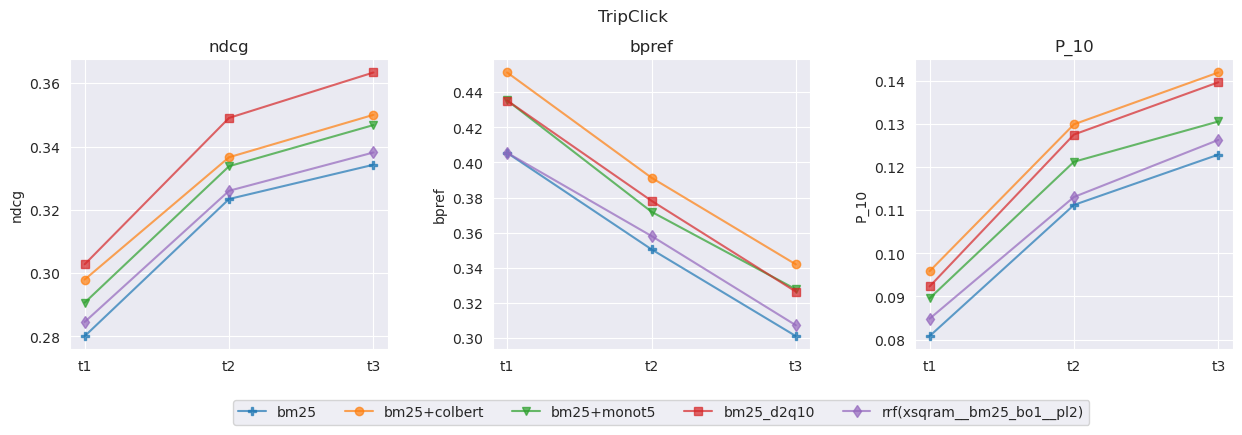

In [15]:
plot_arp("tripclick-test-head", title="TripClick", symbols=["-P","-o","-v","-s", "-d"])

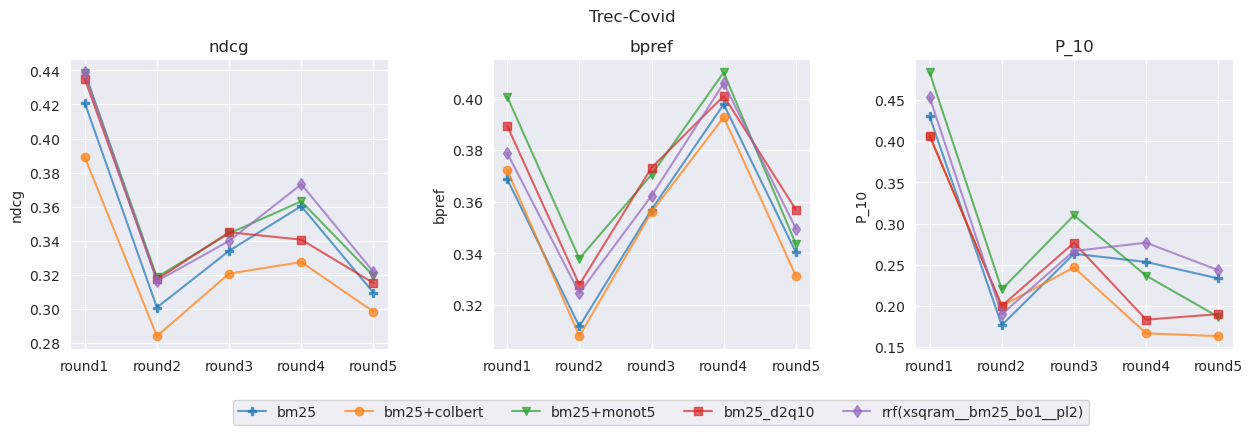

In [16]:
plot_arp("trec-covid", title="Trec-Covid", symbols=["-P","-o","-v","-s", "-d"])

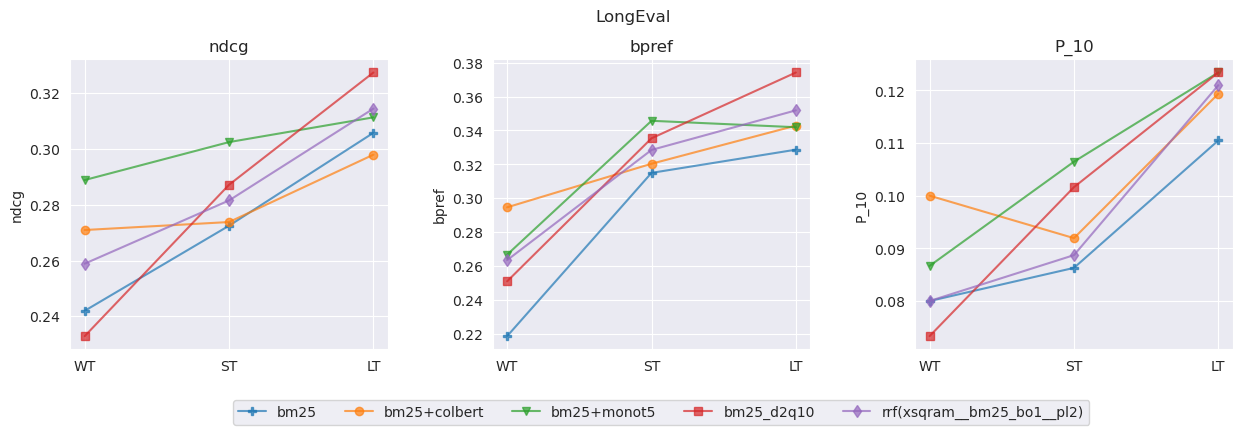

In [17]:
plot_arp("longeval", title="LongEval", symbols=["-P","-o","-v","-s", "-d"], sorted_columns=["WT", "ST", "LT"])

# Plot per topic

In [18]:
def plot_per_topic_dif(dataset, method, measure, subcollections, cut_off=1000):
    colors = ['#1f78b4', '#ff7f00', '#33a02c', '#e31a1b', "#6a3c9a", "#dbdbdb"]
    data = defaultdict(lambda: dict(zip(subcollections, [0 for _ in range(len(subcollections))])))

    fig, ax = plt.subplots(figsize=(30,5))

    for subcollection in subcollections:
        per_topic = runs[(runs["dataset"]==dataset)&(runs["subcollection"]==subcollection) & (runs["method"]==method)].iloc[0]["arp_per_topic"]

        for topic in per_topic.keys():
            data[topic][subcollection] = per_topic[topic][measure]

    data = pd.DataFrame(data).T.head(cut_off)
    # return data
    for idx, subcollection in enumerate(subcollections):
        x = data[subcollection]
        ax.plot(x, label=subcollection, color=colors[idx])
        ax.fill_between(x.index, x, 0 , alpha=0.2, color=colors[idx])

    ax.legend()
    ax.set_ylabel(measure)
    ax.set_title(dataset)

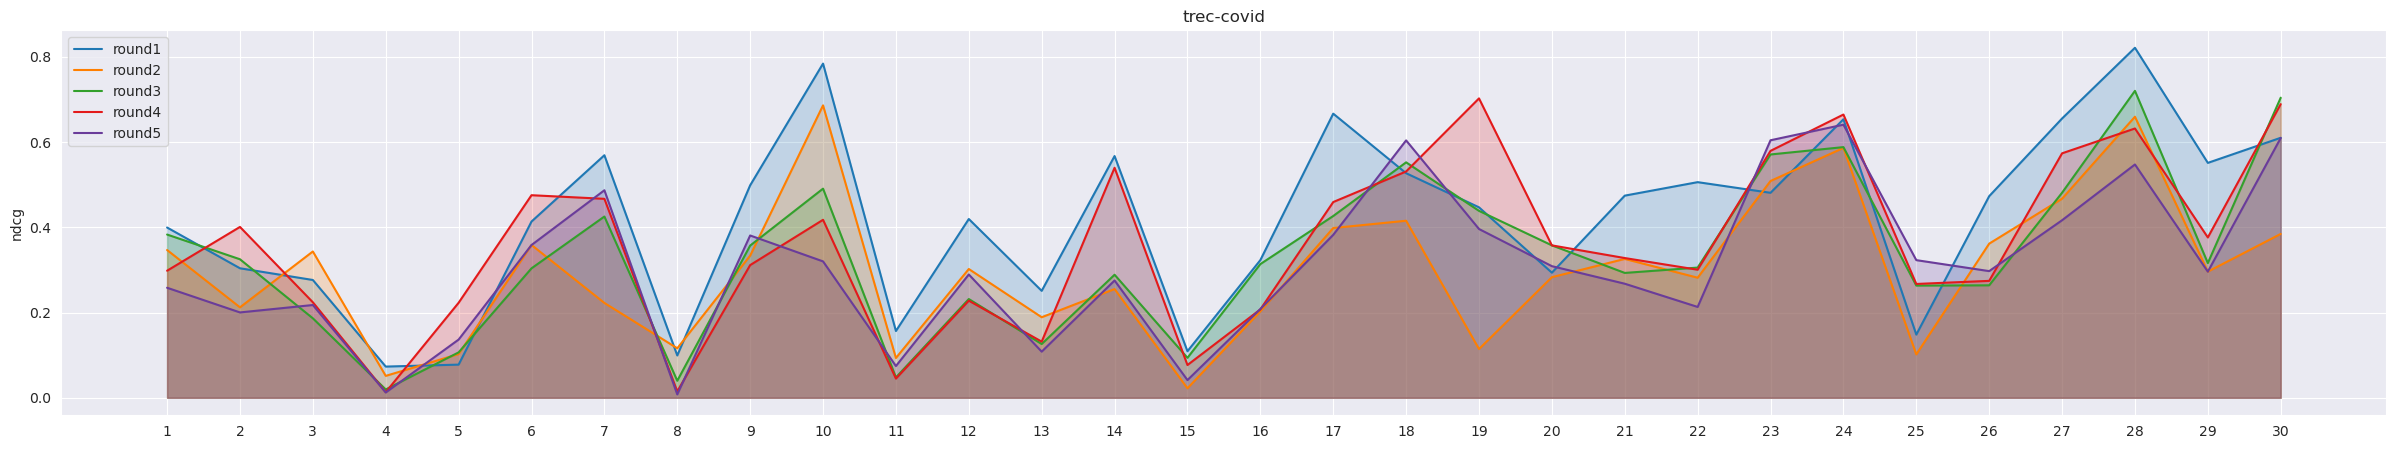

In [19]:
plot_per_topic_dif("trec-covid", "bm25", "ndcg", subcollections = ["round1", "round2", "round3", "round4", "round5"])

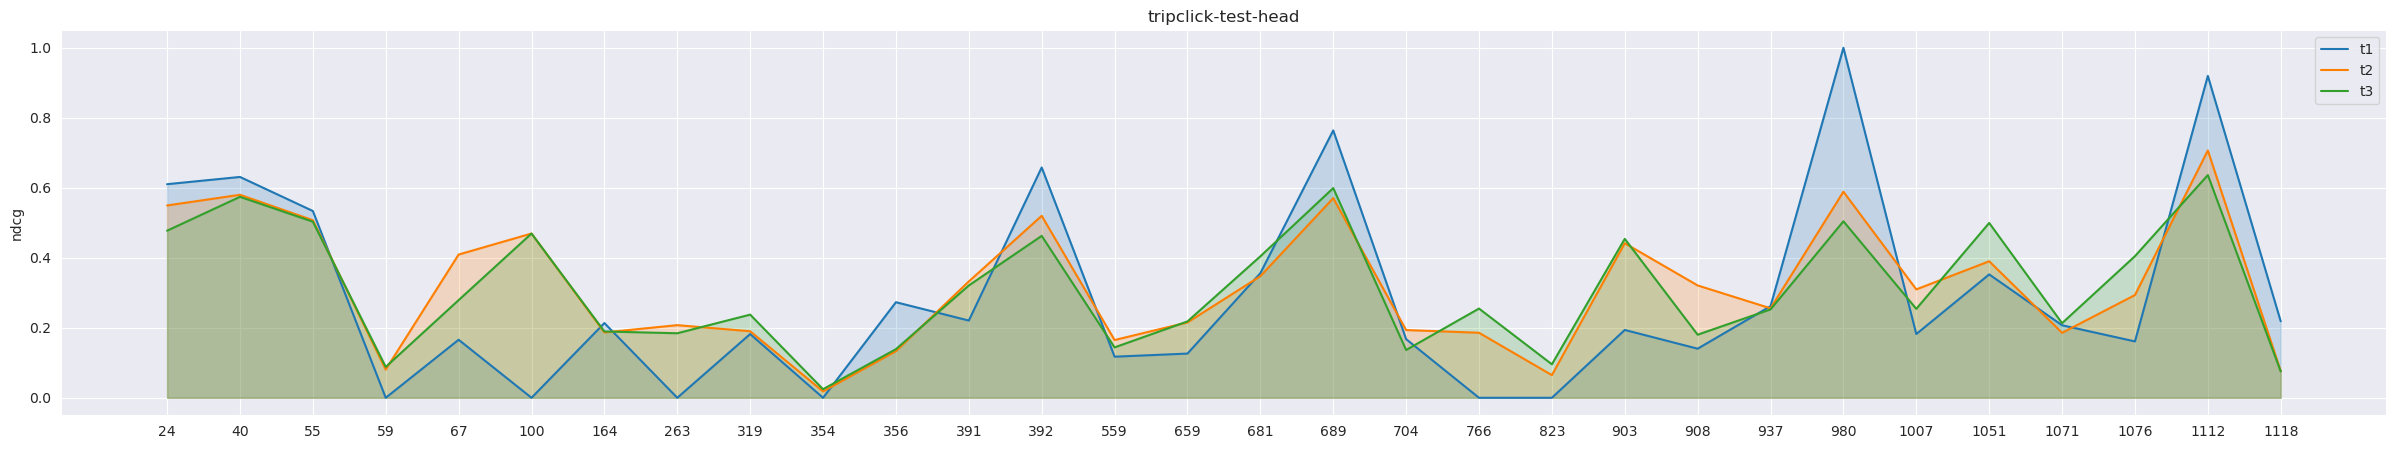

In [20]:
plot_per_topic_dif("tripclick-test-head", "bm25", "ndcg", subcollections=["t1", "t2", "t3"], cut_off=30)

In [21]:
def plot_per_topic(dataset, method, measure, subcollections, cut_off=1000):
    colors = ['#1f78b4', '#ff7f00', '#33a02c', '#e31a1b', "#6a3c9a", "#dbdbdb"]
    data = defaultdict(lambda: dict(zip(subcollections, [0 for _ in range(len(subcollections))])))

    # fig, ax = plt.subplots(figsize=(30,5))

    for subcollection in subcollections:
        per_topic = runs[(runs["dataset"]==dataset) & (runs["subcollection"]==subcollection) & (runs["method"]==method)].iloc[0]["arp_per_topic"]

        for topic in per_topic.keys():
            data[topic][subcollection] = per_topic[topic][measure]

    data = pd.DataFrame(data).T.head(cut_off)
    ax = data.plot(kind="bar", figsize=(30,5))

    ax.legend()
    ax.set_ylabel(measure)
    ax.set_title(dataset)

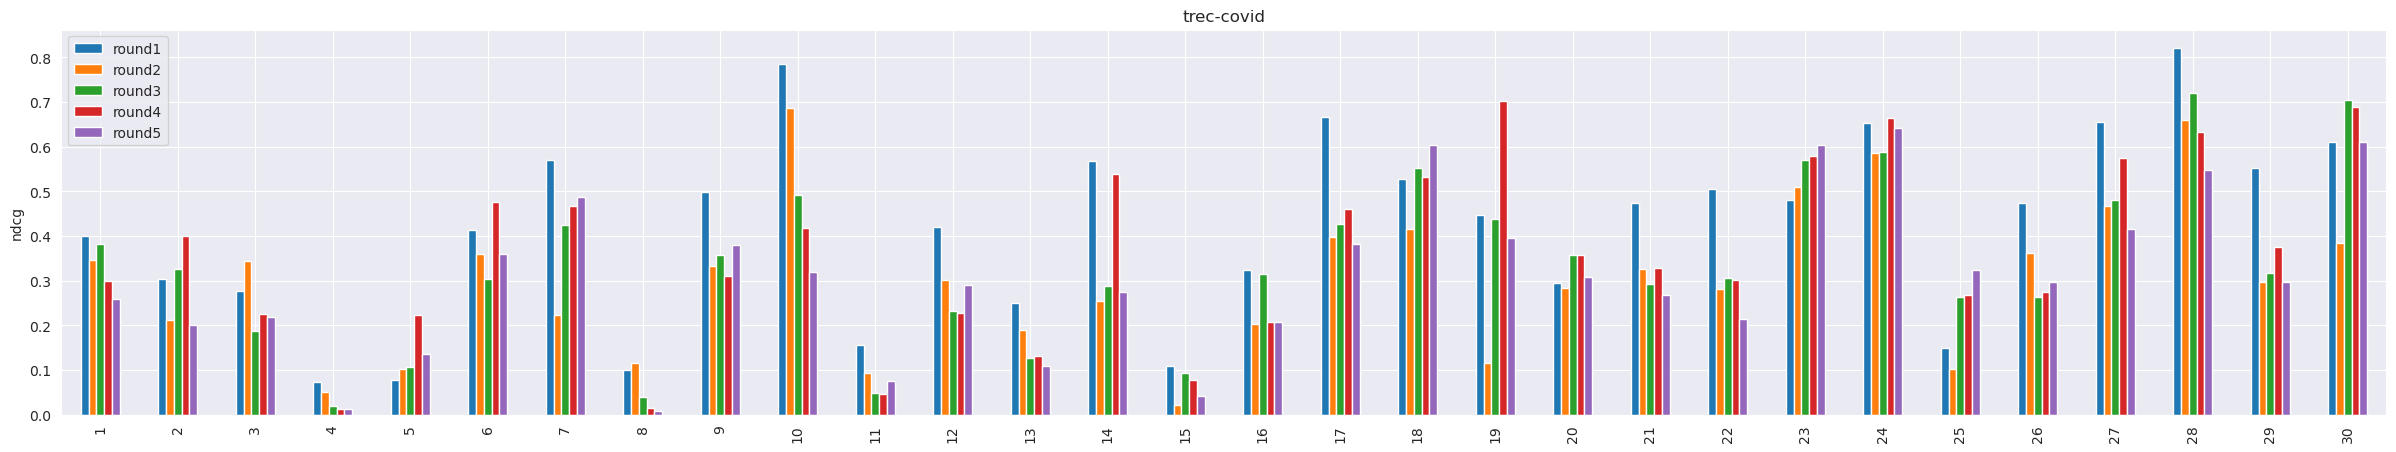

In [22]:
plot_per_topic("trec-covid", "bm25", "ndcg", subcollections = ["round1", "round2", "round3", "round4", "round5"], cut_off=30)

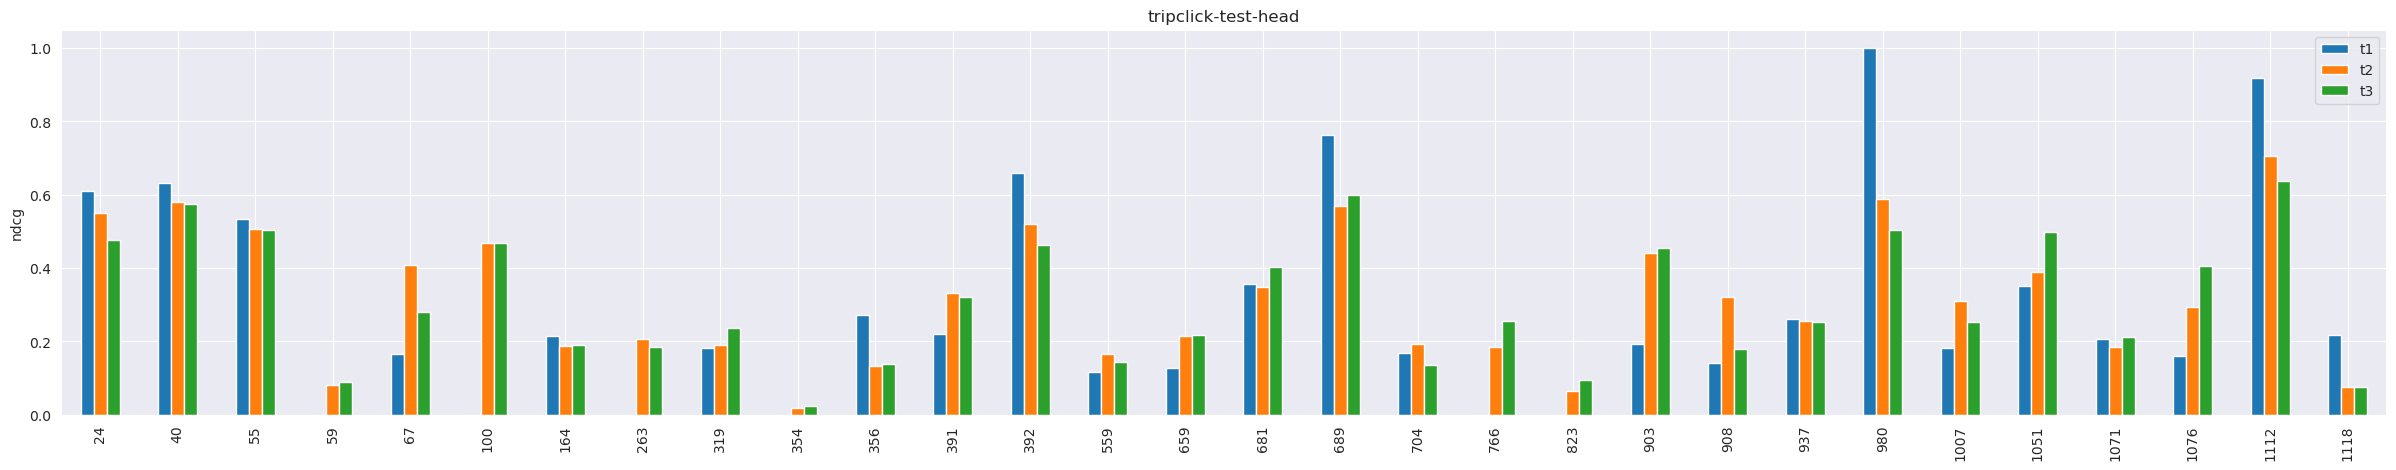

In [23]:
plot_per_topic("tripclick-test-head", "bm25", "ndcg", subcollections=["t1", "t2", "t3"], cut_off=30)

In [24]:
def plot_per_topic_delta(dataset, method, measure, subcollections, cut_off=1000):
    colors = ['#1f78b4', '#ff7f00', '#33a02c', '#e31a1b', "#6a3c9a", "#dbdbdb"]
    assert len(subcollections) == 2, "Only two subcollections allowed"
    data = defaultdict(lambda: dict(zip(subcollections, [0 for _ in range(len(subcollections))])))

    # fig, ax = plt.subplots(figsize=(30,5))

    for subcollection in subcollections:
        per_topic = runs[(runs["dataset"]==dataset) & (runs["subcollection"]==subcollection) & (runs["method"]==method)].iloc[0]["arp_per_topic"]

        for topic in per_topic.keys():
            data[topic][subcollection] = per_topic[topic][measure]

    data = pd.DataFrame(data).T.head(cut_off)

    data["delta"] = data[subcollections[0]] - data[subcollections[1]]
    ax = data["delta"].sort_values(ascending=False).plot(kind="bar", figsize=(30,5))

    ax.legend()
    ax.set_ylabel(measure)
    ax.set_title(dataset)

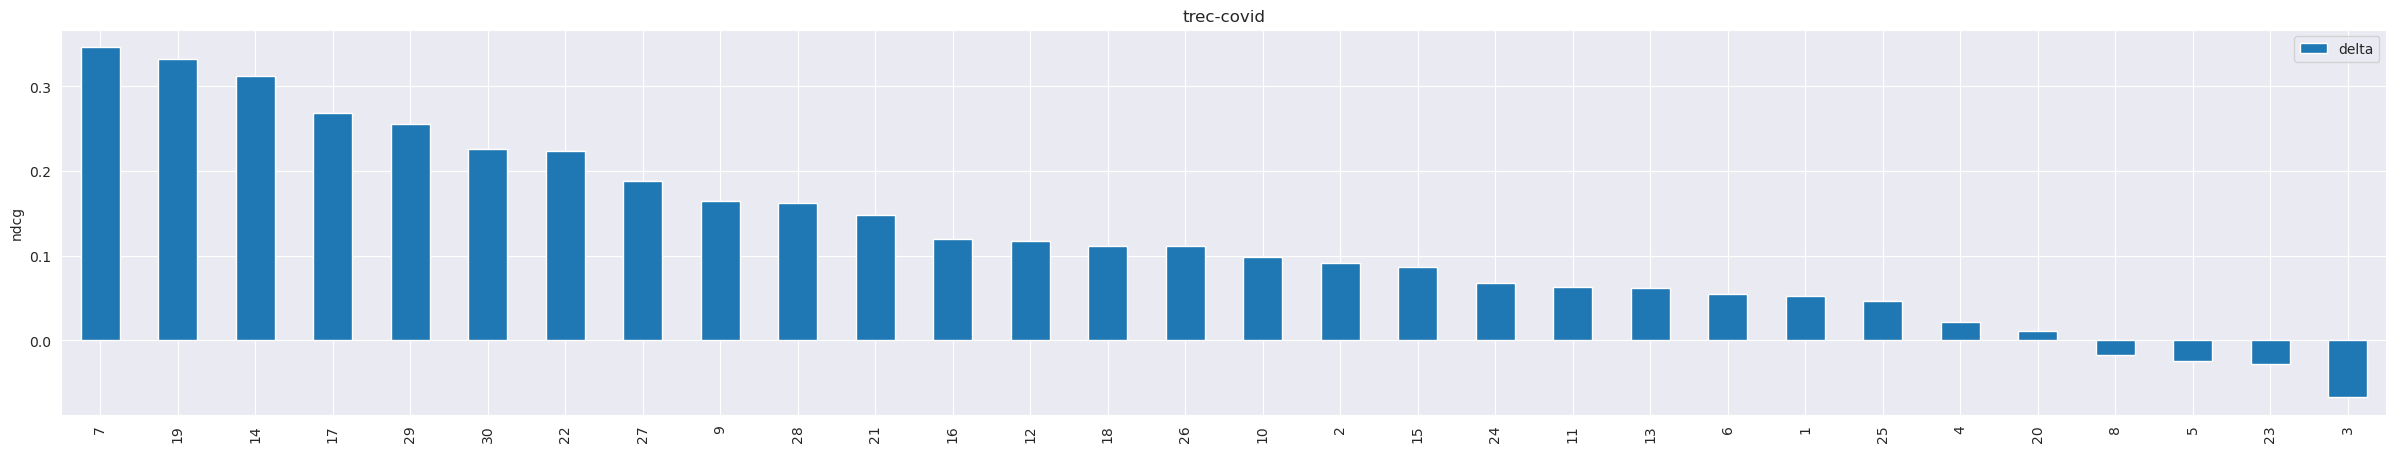

In [25]:
plot_per_topic_delta("trec-covid", "bm25", "ndcg", subcollections = ["round1", "round2"], cut_off=30)

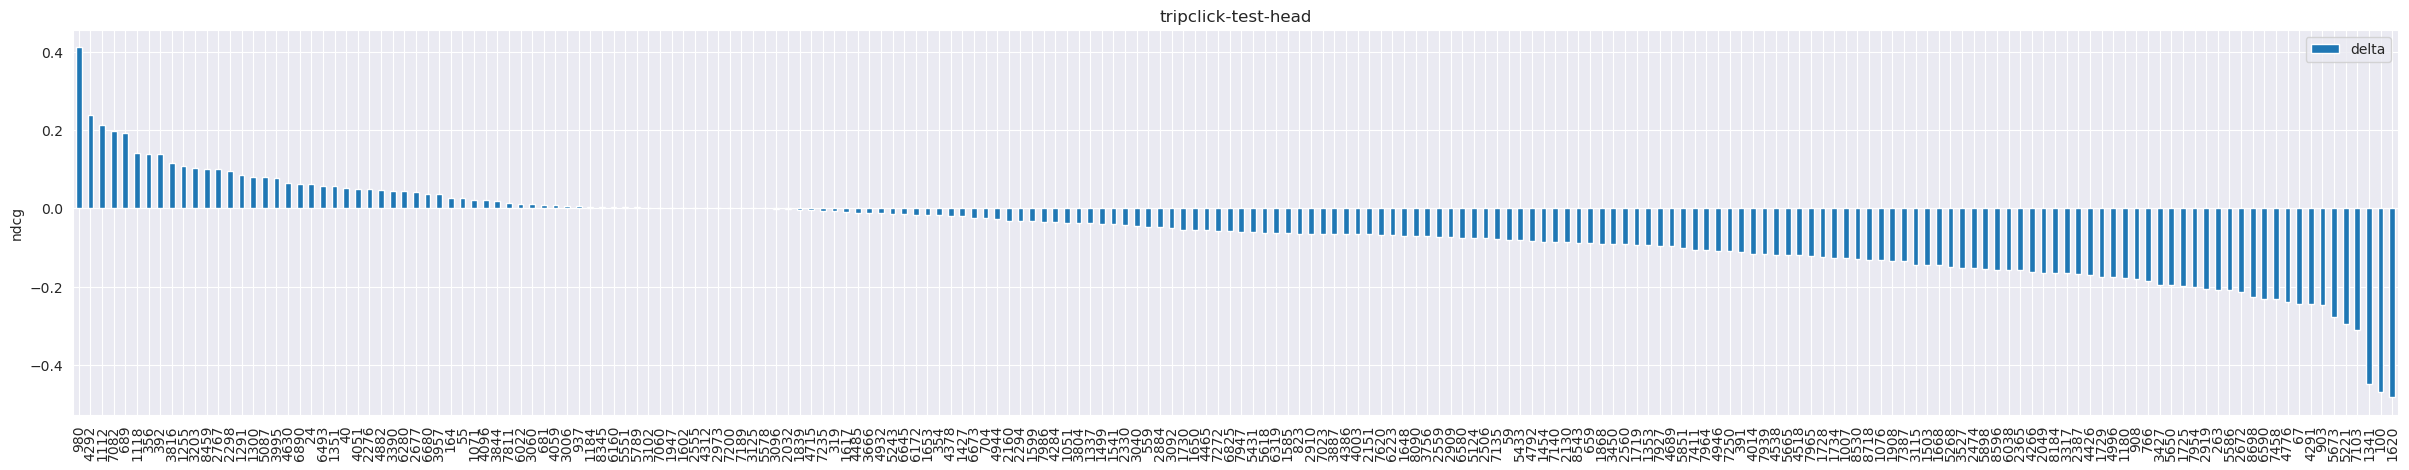

In [26]:
plot_per_topic_delta("tripclick-test-head", "bm25", "ndcg", subcollections=["t1", "t2"], cut_off=200)

# Result Table

In [27]:
def result_table(dataset, measure, subcollections):
    custom_dict = {"bm25": 0, "E5": 5, "bm25+colbert": 2, "bm25+monot5": 3, "bm25_d2q10": 4, "rrf(xsqram__bm25_bo1__pl2)": 1}

    df = runs[runs["dataset"]==dataset]
    columns = ["method", "subcollection"] 
    columns.append(measure)

    df = df[columns]
    df = df.pivot_table(index="method", columns="subcollection", values=measure)
    df = df.reset_index()
    df["sorter"] = df["method"].replace(custom_dict)
    df = df.sort_values("sorter").drop("sorter", axis=1)
    df = df.rename_axis(None, axis=1)

    # Resultdelta
    for subcollection in subcollections[1:]:
        df[subcollections[0]+"-"+subcollection] = df[subcollections[0]]-df[subcollection]
    return df

In [28]:
result_table(dataset="tripclick-test-head", measure="ndcg", subcollections=["t1", "t2", "t3"])

,method,t1,t2,t3,t1-t2,t1-t3
0,bm25,0.280085,0.323421,0.334239,-0.043336,-0.054155
4,rrf(xsqram__bm25_bo1__pl2),0.284571,0.326017,0.338123,-0.041446,-0.053553
1,bm25+colbert,0.297968,0.336617,0.350020,-0.038649,-0.052052
2,bm25+monot5,0.290667,0.333782,0.346788,-0.043115,-0.056121
3,bm25_d2q10,0.302785,0.349050,0.363402,-0.046265,-0.060617


In [29]:
result_table(dataset="trec-covid", measure="ndcg", subcollections=["round1", "round2", "round3", "round4", "round5"])

,method,round1,round2,round3,round4,round5,round1-round2,round1-round3,round1-round4,round1-round5
0,bm25,0.421015,0.300744,0.334036,0.360303,0.309442,0.120270,0.086979,0.060711,0.111573
4,rrf(xsqram__bm25_bo1__pl2),0.438790,0.316279,0.339842,0.373099,0.321717,0.122510,0.098948,0.065691,0.117073
1,bm25+colbert,0.389115,0.283945,0.320650,0.327437,0.298260,0.105171,0.068465,0.061679,0.090855
2,bm25+monot5,0.438722,0.318582,0.344250,0.363079,0.319341,0.120140,0.094472,0.075643,0.119382
3,bm25_d2q10,0.435098,0.317252,0.344969,0.340618,0.315154,0.117846,0.090129,0.094481,0.119944


# Replicability